In [221]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
import numpy as np
from Aggregation import Agregator
import matplotlib.pyplot as plt
from functools import partial

In [223]:
from sklearn.linear_model import LinearRegression

In [224]:
def plot_all(aggregate,X,y_target,y_good,y_bad,trick_data,f_target):
    idx=np.argsort(X)
    X_eval_sorted=X[idx]
    Y_eval_sorted=y_target[idx]
    pred_aggregate_sorted,alpha=aggregate.predict(X_eval_sorted[:,None],return_alpha=True)
    #two plot one on top of the other. first one is evolution of the aggregate, second evolution of alpha

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,figsize=(10,10))


    ax1.set_xlabel('X')
    ax1.set_ylabel('aggregate')
    ax1.tick_params(axis='y')
    for y,model_name in [(y_good,'good'),(y_bad,'bad')]:
        ax1.plot(X_eval_sorted,y[idx],label=model_name,linestyle='--')
    ax1.plot(X_eval_sorted,Y_eval_sorted,label='data')
    ax1.plot(X_eval_sorted,pred_aggregate_sorted,label='aggregate')
    ax1.scatter(trick_data,f_target(trick_data),label='trick_data')
    #ax2 must be a new subplot



    ax2.set_ylabel('alpha')  # we already handled the x-label with ax1
    '''for xi in trick_data:
        ax2.axvline(x=np.sum(xi),color='k',linestyle='--')'''
    for i,model in enumerate(['good','bad']):
        ax2.plot(X_eval_sorted, alpha[i], label=model)
    ax2.tick_params(axis='y')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    return fig

In [225]:
class wrapper:
    def __init__(self, func, *args, **kwargs):
        self.func = func
        self.args = args
        self.kwargs = kwargs
    def predict(self, x):
        return self.func(x)[:,0]

# Example 1

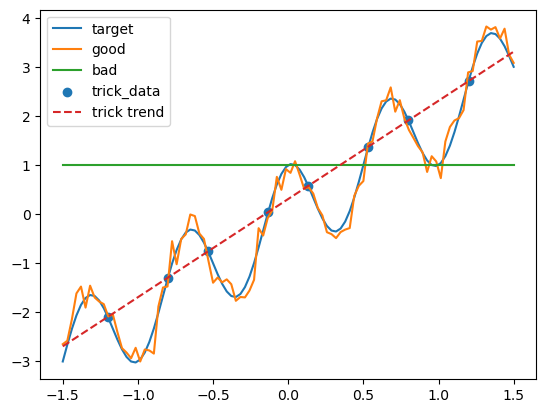

In [226]:
np.random.seed(0)
f_target= lambda x:2*x+np.cos(3*np.pi*x)
good_model=lambda x:f_target(x)+np.random.normal(0,0.2,size=x.shape)
bad_model=lambda x:np.ones_like(x)
X=np.linspace(-1.5,1.5,100)
y_target=f_target(X)
y_good=good_model(X)
y_bad=bad_model(X)

phi=0.2
trick_data=np.array([-1+phi+2*k/3 for k in range(4)]+[1-phi-2*k/3 for k in range(4)])
intercept=f_target(trick_data)[0]-2*trick_data[0]

#plot
plt.plot(X,y_target,label='target')
plt.plot(X,y_good,label='good')
plt.plot(X,y_bad,label='bad')
plt.scatter(trick_data,f_target(trick_data),label='trick_data')
plt.plot(X,2*X+intercept,label='trick trend',linestyle='--')
plt.legend()
plt.show()

In [227]:
def linear_separable_kernel(x,y,mat):
    K=x@y.T
    return K[:,:,None,None]*mat[None,None,:,:]

my_kernel=partial(linear_separable_kernel,mat=np.eye(2))

In [228]:
aggregate=Agregator(K=my_kernel,models=[wrapper(good_model),wrapper(bad_model)],kernel_name='linear',intercept_choice='fit')

# No noise, No regularization

In [229]:
aggregate_no_noise_no_regularization=aggregate.fit(trick_data[:,None],f_target(trick_data),alpha=1e-4)

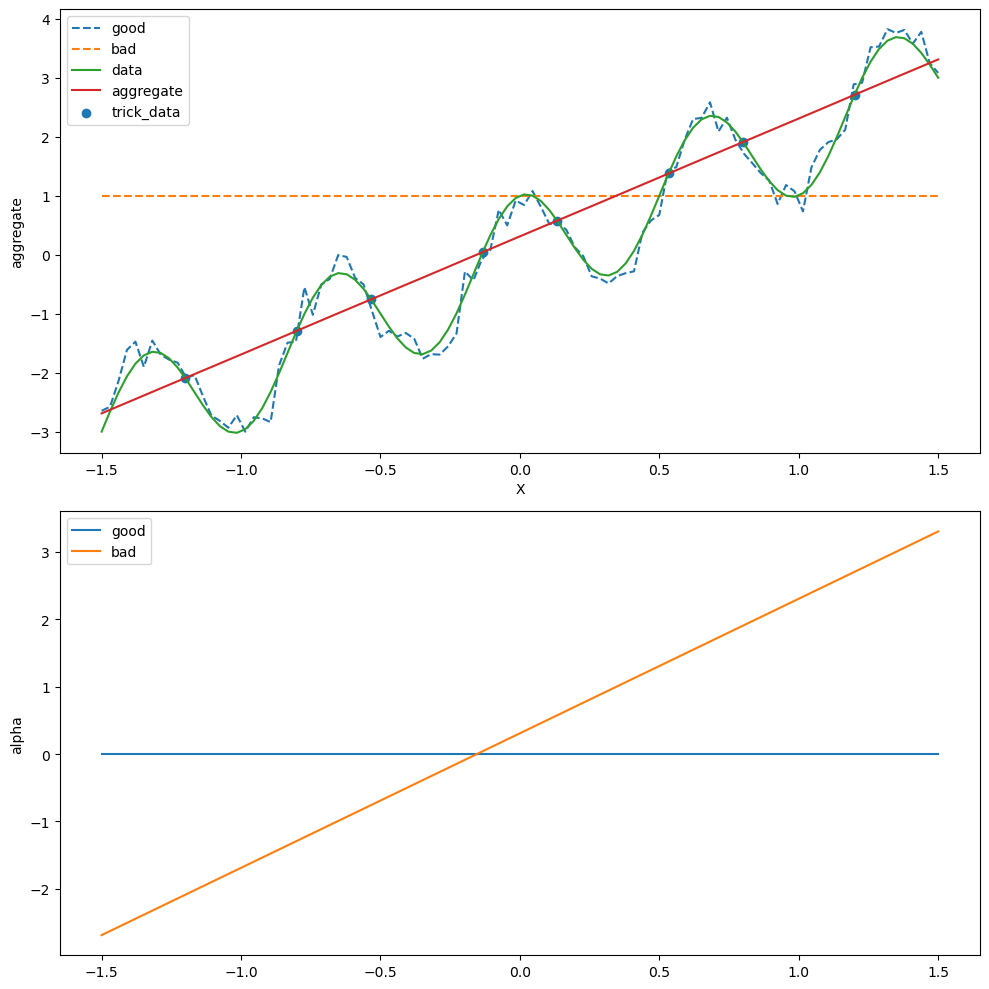

In [230]:
fig=plot_all(aggregate_no_noise_no_regularization,X,y_target,y_good,y_bad,trick_data,f_target)
plt.show()

# No regularization, but noise

In [231]:
aggregate_noise_no_regularization=aggregate.fit(trick_data[:,None],f_target(trick_data)+np.random.normal(0,0.1,size=trick_data.shape),alpha=1e-9)

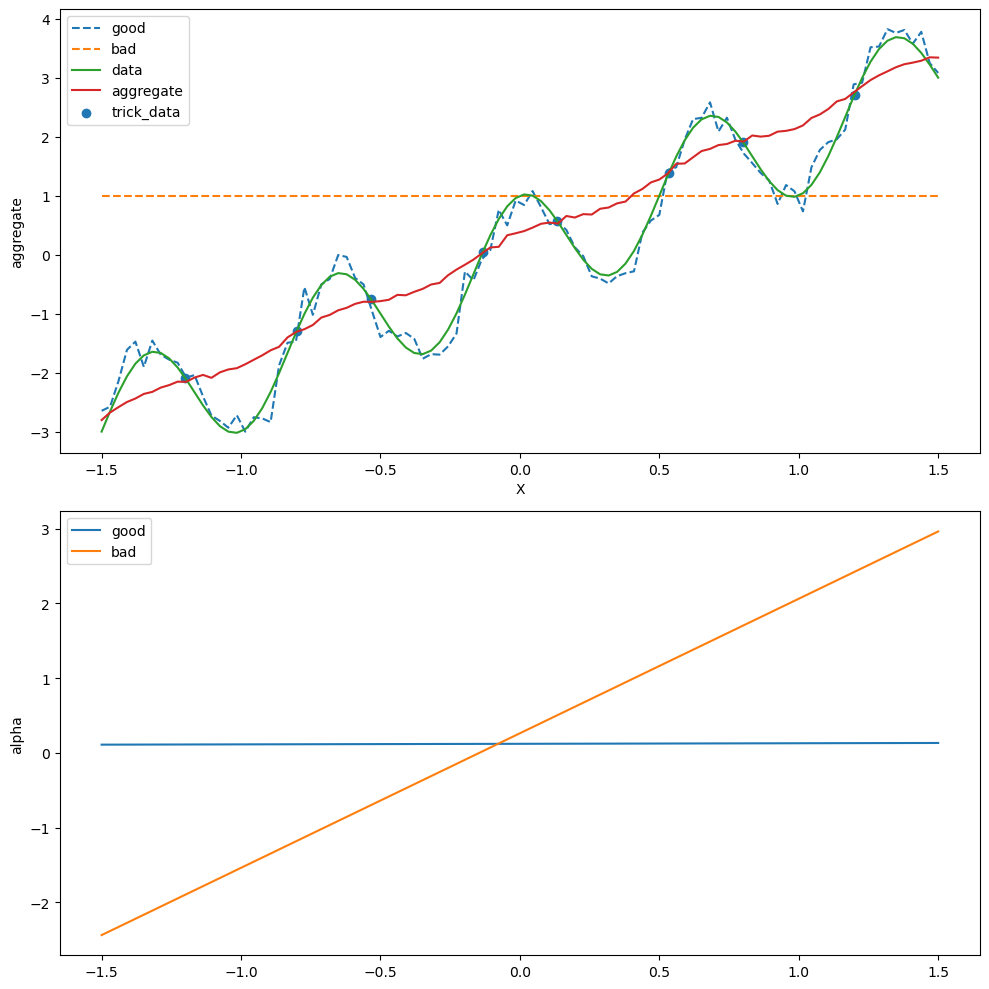

In [232]:
fig=plot_all(aggregate_noise_no_regularization,X,y_target,y_good,y_bad,trick_data,f_target)
plt.show()

# No noise, regularization

In [233]:
aggregate_no_noise_regularization=aggregate.fit(trick_data[:,None],f_target(trick_data),alpha=1)

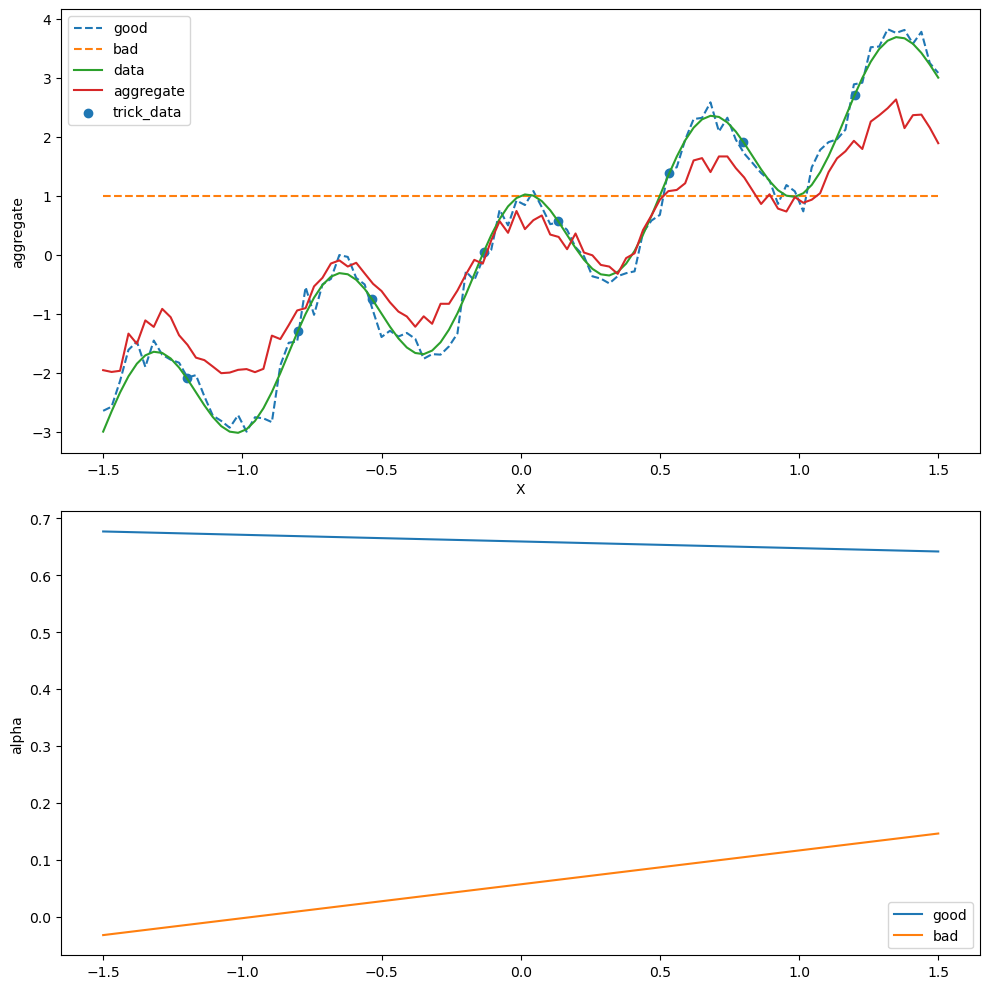

In [234]:
fig=plot_all(aggregate_no_noise_regularization,X,y_target,y_good,y_bad,trick_data,f_target)
plt.show()

# Noise and regularization

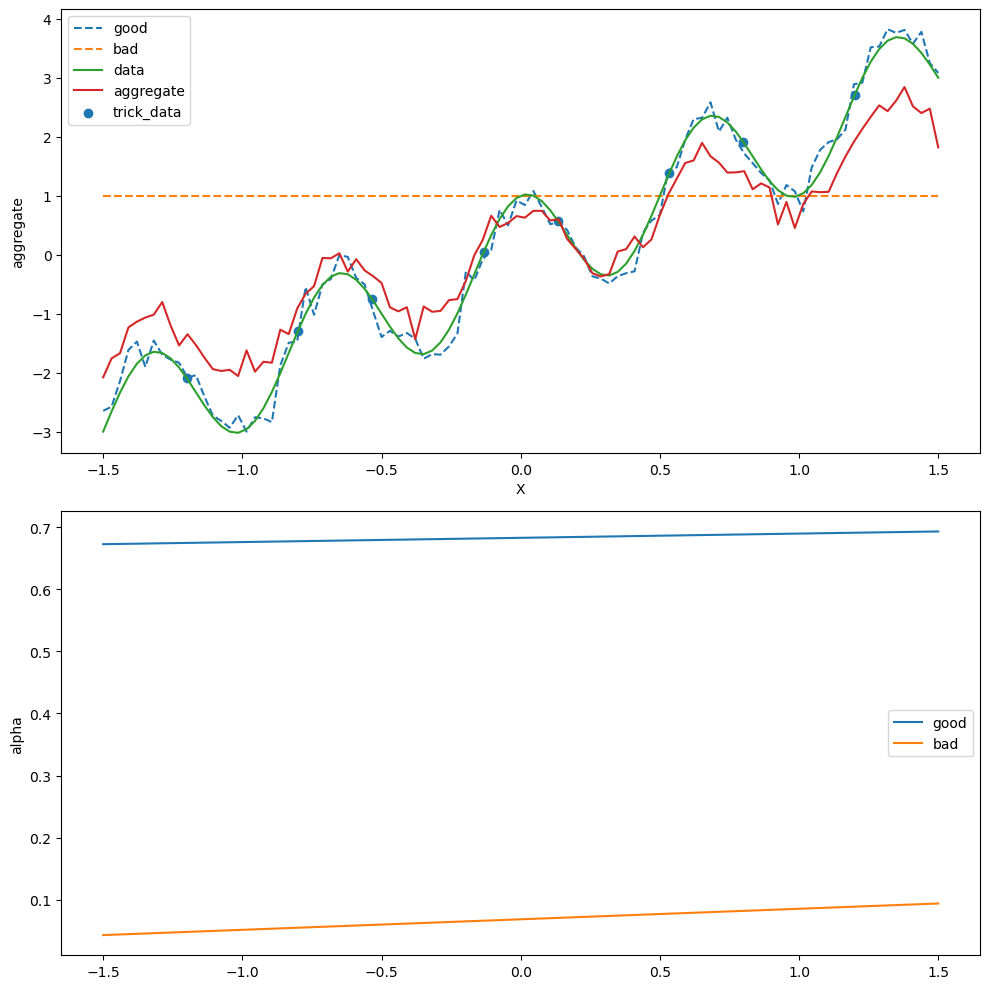

In [235]:
aggregate_noise_regularization=aggregate.fit(trick_data[:,None],f_target(trick_data)+np.random.normal(0,0.1,size=trick_data.shape),alpha=1)
fig=plot_all(aggregate_noise_regularization,X,y_target,y_good,y_bad,trick_data,f_target)
plt.show()

# Example 2

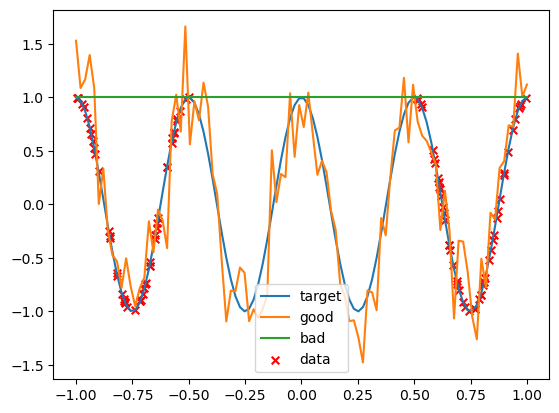

In [236]:
np.random.seed(0)
f_target= lambda x:np.cos(4*np.pi*x)
good_model=lambda x:f_target(x)+np.random.normal(0,0.3,size=x.shape)
bad_model=lambda x:np.ones_like(x)
X=np.linspace(-1,1,100)
y_target=f_target(X)
y_good=good_model(X)
y_bad=bad_model(X)

N=100
data=np.concatenate([np.random.rand(N//2)/2-1,np.random.rand(N//2)/2+1/2])

#plot
plt.plot(X,y_target,label='target')
plt.plot(X,y_good,label='good')
plt.plot(X,y_bad,label='bad')
plt.scatter(data,f_target(data),label='data',s=30,color='r',marker='x')
plt.legend()
plt.show()

In [237]:
from sklearn.metrics.pairwise import rbf_kernel
def gaussian_separable_kernel(x,y,mat,l):
    K=rbf_kernel(x,y,gamma=1/l**2)+0.1
    return K[:,:,None,None]*mat[None,None,:,:]

my_kernel=partial(gaussian_separable_kernel,mat=np.eye(2),l=1)

In [238]:
aggregate=Agregator(K=my_kernel,models=[wrapper(good_model),wrapper(bad_model)],kernel_name='gaussian',intercept_choice='fit')

# No noise no regularization

In [239]:
aggregate_no_noise_no_regularization=aggregate.fit(data[:,None],f_target(data),alpha=1e-9)

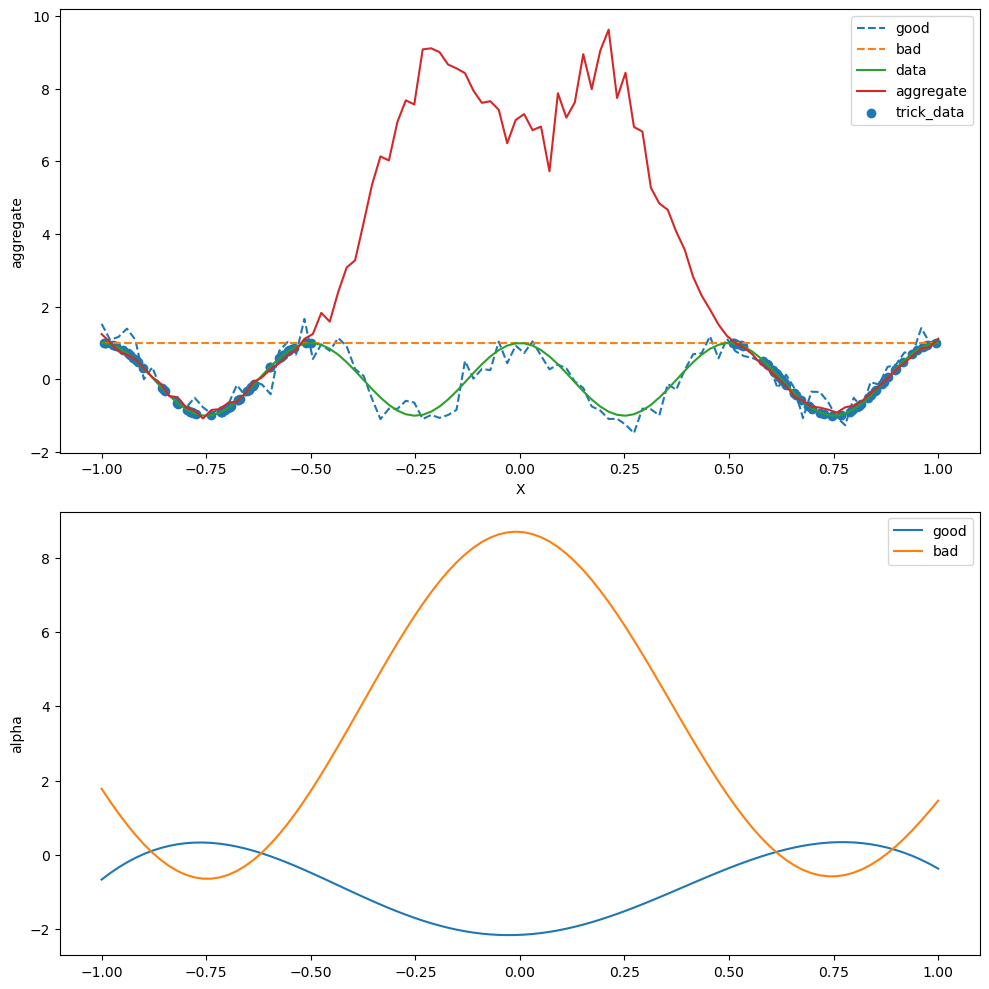

In [240]:
fig=plot_all(aggregate_no_noise_no_regularization,X,y_target,y_good,y_bad,data,f_target)
plt.show()

# No noise regularization

In [241]:
aggregate_no_noise_regularization=aggregate.fit(data[:,None],f_target(data),alpha=1)

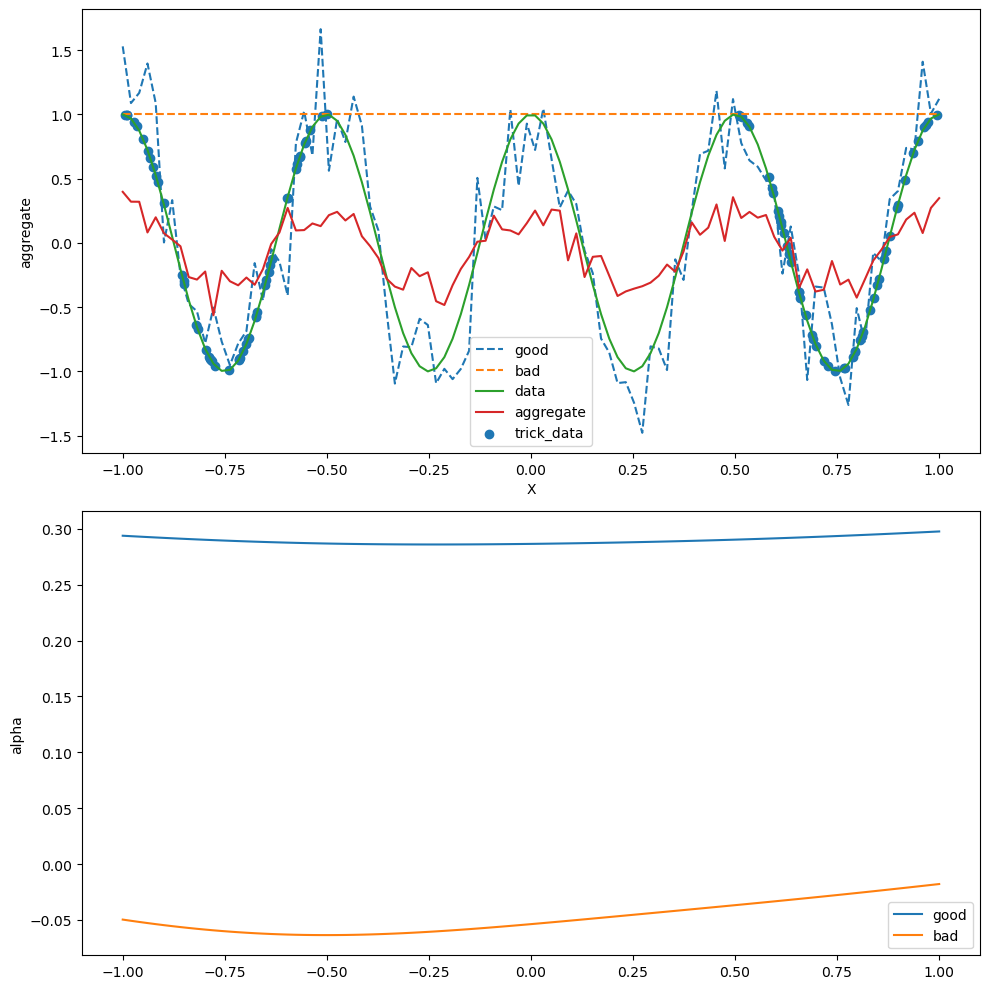

In [242]:
fig=plot_all(aggregate_no_noise_regularization,X,y_target,y_good,y_bad,data,f_target)
plt.show()

# noise no regularization

In [244]:
aggregate_noise_no_regularization=aggregate.fit(data[:,None],f_target(data)+np.random.normal(0,0.1,size=data.shape),alpha=1e-9)

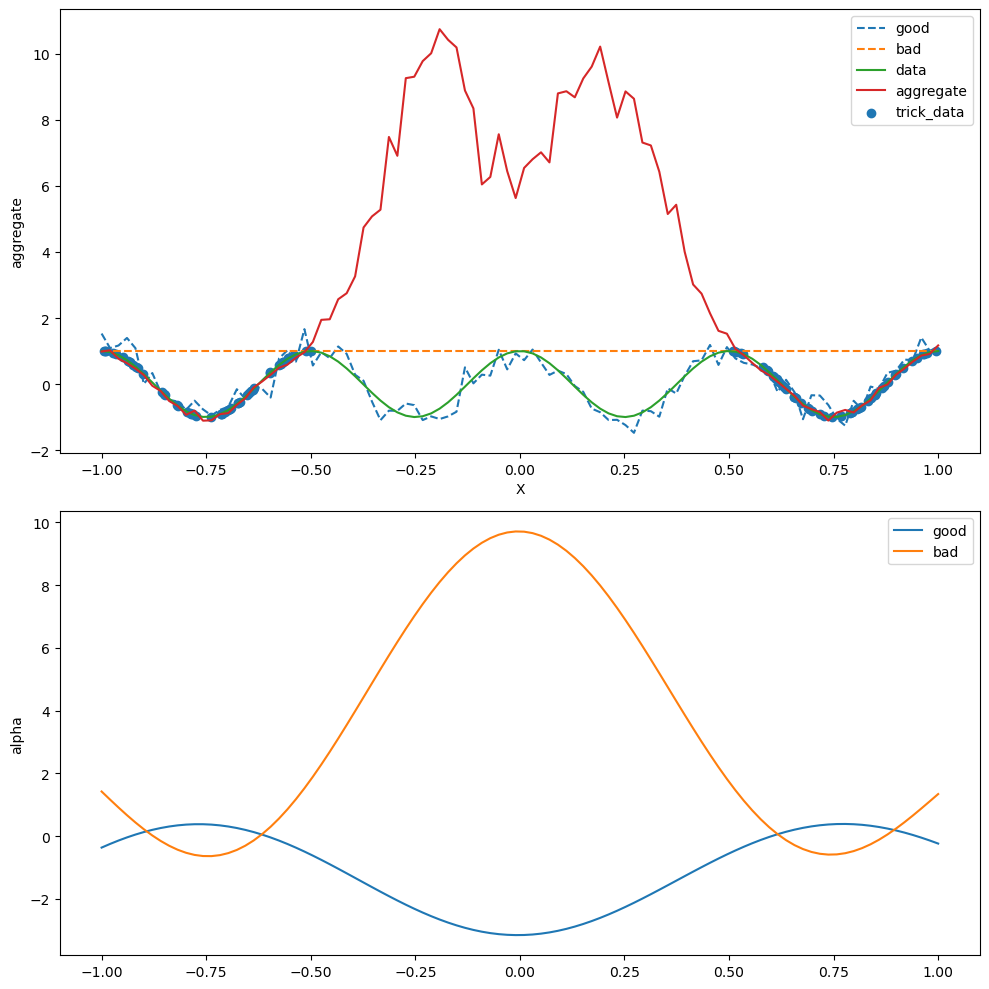

In [245]:
fig=plot_all(aggregate_noise_no_regularization,X,y_target,y_good,y_bad,data,f_target)
plt.show()

# Noise regularization

In [247]:
aggregate_noise_regularization=aggregate.fit(data[:,None],f_target(data)+np.random.normal(0,0.1,size=data.shape),alpha=1)

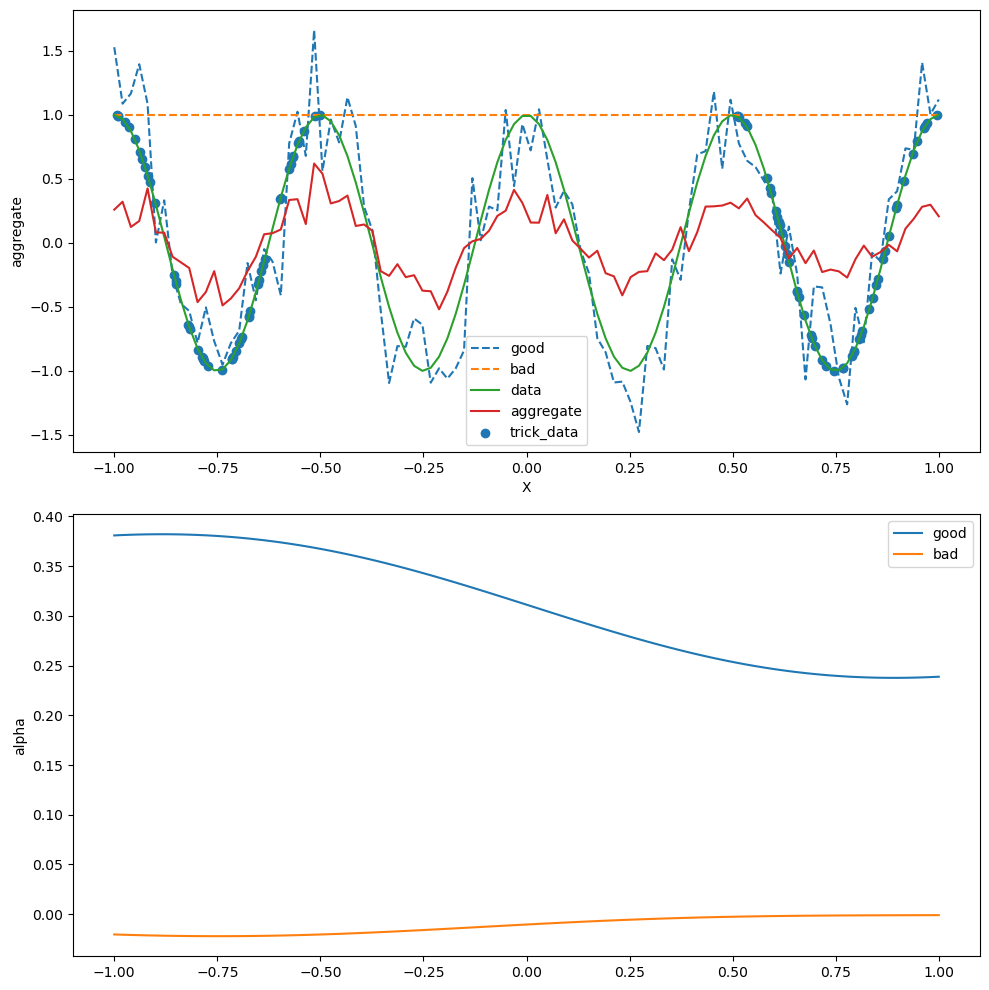

In [248]:
fig=plot_all(aggregate_noise_regularization,X,y_target,y_good,y_bad,data,f_target)
plt.show()